Compute the full dynamics induced by a two-body ising coulping Hamiltonian with heating rate, 
compare the result with the dynamics under a pure spin interaction approximation.

In [147]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import Qsim.operator.spin as spin
import Qsim.operator.phonon as phon
import Qsim.ion_chain.ising.ising_ps as iscp
import Qsim.ion_chain.ising.ising_c as iscc
import Qsim.operator.spin_phonon as sp_op
import Qsim.ion_chain.interaction.spin_phonon as Isp
from  Qsim.ion_chain.ion_system import *
from scipy import signal
import copy
import Qsim.ion_chain.interaction.dissipation as disp

In [148]:
help(tensor)
help(spin)

Help on function tensor in module qutip.tensor:

tensor(*args)
    Calculates the tensor product of input operators.
    
    Parameters
    ----------
    args : array_like
        ``list`` or ``array`` of quantum objects for tensor product.
    
    Returns
    -------
    obj : qobj
        A composite quantum object.
    
    Examples
    --------
    >>> tensor([sigmax(), sigmax()]) # doctest: +SKIP
    Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isHerm = True
    Qobj data =
    [[ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]
     [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
     [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
     [ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]]

Help on module Qsim.operator.spin in Qsim.operator:

NAME
    Qsim.operator.spin

DESCRIPTION
    Operators on spin space
    functions: sx, sy, sz, sry, zero_op, sI, phid, phiup, spin_state   
    @author: zhumj

FUNCTIONS
    bloch_redfield_tensor(...)
         Calculates the time-independent Bloch-Redfield tensor for a system

In [172]:
#Simulation for a phonon system with dissipation only, check if the Lindbladian is working   
ion_sys = ions(trap_config={'N': 2, 'fx': 2.732, 'fz': 1.16}, 
                   numeric_config={'active_spin': [0],'active_phonon': [[0,1]], 'pcut': [[50,2]]},
                   )
ion_sys.list_para() #print parameters of the system

Trap coefficients updated
Anharmonic coefficients updated
_____________________________________________________________
Checking phonon space setup
Phonon space setups are consistent
_____________________________________________________________
Phonon space parameters updated
Cooling parameters updated
Trap parametric modulation updated
Ions class object initialized.
________________________________________________________________
********************Setup of the Trap************************
number of ions 2
Axial COM (Confining) frequency  1.16  [MHz]
Radial COM (Confining) frequency  2.73 [MHz]
Axial vibrational eigenfrequency [1.16 2.01] MHz
Radial (Transverse) vibrational eigenfrequency [2.73 2.47] [MHz]
Modulation Amplitude for parameteric amplification:  [0] [V]
Modulation Frequency for parameteric amplification:  [0] [MHz]
Trap dimension parameter:  200 [um]
                                                                 
********************Config of Numeric Calculation*******

In [173]:
#%%time evolution, assume the dissipation rate is 0.1 quanta/ms
clist = disp.heating(ion_sys,[0.1/(2*np.pi),0.04/(2*np.pi)],1)
spinstate=[0]
rho = sp_op.ini_state(ion_sys,[0],[[0,0]],0)
rho0 = sp_op.rho_thermal(ion_sys,nbar_list=[[1,0.01]],s_state=[0],ket = False)
H0 = tensor(spin.zero_op(N=1),sp_op.p_zero(ion_sys))
times =  np.arange(0,1,10**(-4))
result0 = mesolve(H0,rho0,times,clist,progress_bar=True,options=Options(nsteps=1000)) 

10.0%. Run time:   0.63s. Est. time left: 00:00:00:05
20.0%. Run time:   1.35s. Est. time left: 00:00:00:05
30.0%. Run time:   2.02s. Est. time left: 00:00:00:04
40.0%. Run time:   2.64s. Est. time left: 00:00:00:03
50.0%. Run time:   3.28s. Est. time left: 00:00:00:03
60.0%. Run time:   3.85s. Est. time left: 00:00:00:02
70.0%. Run time:   4.40s. Est. time left: 00:00:00:01
80.0%. Run time:   4.95s. Est. time left: 00:00:00:01
90.0%. Run time:   5.52s. Est. time left: 00:00:00:00
Total run time:   6.14s


Maximum phonon population of highest com phonon space =  1.0999899998888556 and 0.047488322789083


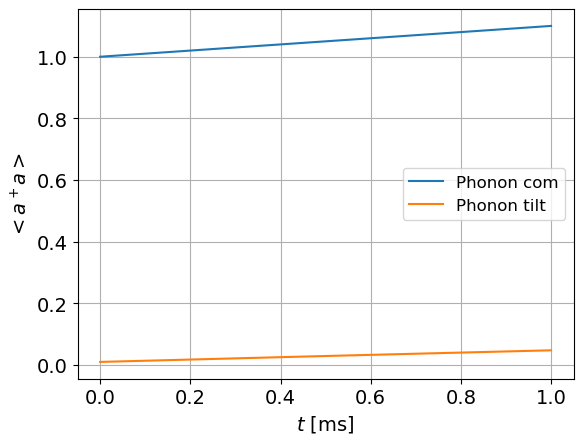

In [174]:
#%%plot phonon population 
df_p = 1 #for phonon measurements
mp_state1 = expect(sp_op.pstate_measure(ion_sys,df_p,49,0),result0.states) 
pplot = expect(sp_op.phonon_measure(ion_sys,df_p, mindex=0), result0.states)
pplot1 = expect(sp_op.phonon_measure(ion_sys,df_p, mindex=1), result0.states)
print('Maximum phonon population of highest com phonon space = ', np.max(pplot),'and', np.max(pplot1) )
plt.plot(times,pplot,label = 'Phonon com')
plt.plot(times,pplot1,label = 'Phonon tilt')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<a^+ a>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

In [187]:
#%%
'''
2body MS simulation for time-depedent Hamiltonian under RWA, drive the com mode,
first assume a small heating rate of 0.1 quanta/ms  
'''
com_cut = 8; tilt_cut = 3
ion_sys.update_numeric(numeric_config={'active_spin': [0,1],'active_phonon': [[0,1]], 'pcut': [[com_cut,tilt_cut]]})
Bz = 0 #Effective magnetic field
N = ion_sys.N
print("fx =", ion_sys.fx)
nuy=ion_sys.radial_freq
det=-110 #kHz, south of the lowest mode
print("detuning =",det,"kHz")
spin_config = np.array([1,1])
ion_sys.list_para()
#construct Hamiltonian 
laser1 = Laser(config = {'Omega_eff':38,'wavevector':1,'Dk':np.sqrt(2)*2*np.pi / (355*10**(-9)),
                         'laser_couple':[0,1], 'mu':1e3*nuy[1]+det,'phase':0})
laser1.list_para()
print("J =",iscp.Jt(ion_sys,laser1))
print("df =", ion_sys.df_cooling)
clist1 = disp.heating(ion_sys,[0.1/(2*np.pi),0.04/(2*np.pi)],df=1) #Dissipation
Heff,arg0 = iscc.H_ord(Bz,ion_sys,laser1) #construct time-dependent H
#construct initial state (initialized as up up)
rho1 = sp_op.ini_state(ion_sys,spin_config,[[0,0]],0)#pure state
rho0 = sp_op.rho_thermal(ion_sys,nbar_list=[[1,0.01]],s_state=spin_config,ket = False)#thermal state
elist1 = [tensor(spin.sz(N,0),sp_op.p_I(ion_sys)),#spin1
          tensor(spin.sz(N,1),sp_op.p_I(ion_sys)),#spin2
          sp_op.phonon_measure(ion_sys,df_p, mindex=0),#com mode population
          sp_op.phonon_measure(ion_sys,df_p, mindex=1),#tilt mode population
          sp_op.pstate_measure(ion_sys,df_p,com_cut-1,0),#population of com_mode cutoff
          sp_op.pstate_measure(ion_sys,df_p,tilt_cut-1,1)] #population of com_mode cutoff
times =  np.arange(0,0.5,10**(-4))

_____________________________________________________________
Checking phonon space setup
Phonon space setups are consistent
_____________________________________________________________
Phonon space parameters updated
fx = 2.732
detuning = -110 kHz
________________________________________________________________
********************Setup of the Trap************************
number of ions 2
Axial COM (Confining) frequency  1.16  [MHz]
Radial COM (Confining) frequency  2.73 [MHz]
Axial vibrational eigenfrequency [1.16 2.01] MHz
Radial (Transverse) vibrational eigenfrequency [2.73 2.47] [MHz]
Modulation Amplitude for parameteric amplification:  [0] [V]
Modulation Frequency for parameteric amplification:  [0] [MHz]
Trap dimension parameter:  200 [um]
                                                                 
********************Config of Numeric Calculation************************
index of phonon space included in simulation:  [[0, 1]]
corresonding phonon space cutoff  [[8, 3]]
***

In [188]:
#solve time dependent ME
print('______________________________________________________________________')
print('solving for complete Hamiltonian')
result1 = mesolve(Heff,rho0,times,clist1,args = arg0,progress_bar=True,options=Options(nsteps=1000)) 

______________________________________________________________________
solving for complete Hamiltonian
10.0%. Run time:   2.46s. Est. time left: 00:00:00:22
20.0%. Run time:   4.90s. Est. time left: 00:00:00:19
30.0%. Run time:   7.38s. Est. time left: 00:00:00:17
40.0%. Run time:   9.85s. Est. time left: 00:00:00:14
50.0%. Run time:  12.32s. Est. time left: 00:00:00:12
60.0%. Run time:  14.75s. Est. time left: 00:00:00:09
70.0%. Run time:  17.21s. Est. time left: 00:00:00:07
80.0%. Run time:  19.66s. Est. time left: 00:00:00:04
90.0%. Run time:  22.16s. Est. time left: 00:00:00:02
Total run time:  24.59s


In [189]:
#simulation with a pure spin approximation
psi0 = spin.spin_state(N,[1,1])  
J = iscp.Jt(ion_sys,laser1)
elist2 = [spin.sz(N,0),spin.sz(N,1)]
H = iscp.Hps(J,ion_sys,Bz)
print('______________________________________________________________________')
print('solving for pure spin interaction')
result = mesolve(H,psi0,times,e_ops=elist2,progress_bar=True, options=Options(nsteps=1000))

______________________________________________________________________
solving for pure spin interaction
10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
30.0%. Run time:   0.05s. Est. time left: 00:00:00:00
40.0%. Run time:   0.07s. Est. time left: 00:00:00:00
50.0%. Run time:   0.09s. Est. time left: 00:00:00:00
60.0%. Run time:   0.11s. Est. time left: 00:00:00:00
70.0%. Run time:   0.12s. Est. time left: 00:00:00:00
80.0%. Run time:   0.14s. Est. time left: 00:00:00:00
90.0%. Run time:   0.16s. Est. time left: 00:00:00:00
Total run time:   0.18s


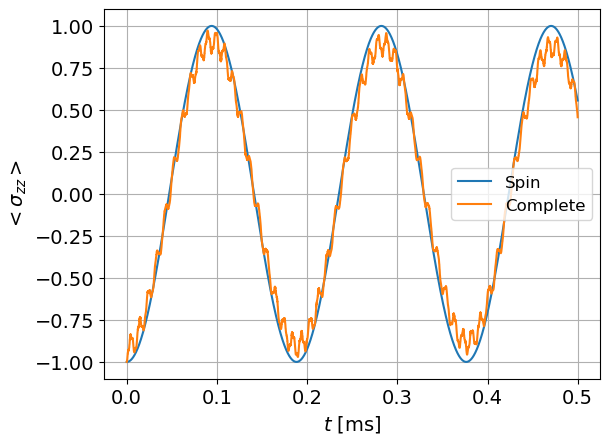

In [191]:
#plot spin dynamics
p0 = 0.5*(result.expect[0]+result.expect[1])
p1 = 0.5*(expect(elist1[0], result1.states)+expect(elist1[1], result1.states))
plt.plot(times,p0,label = 'Spin')
plt.plot(times,p1,label = 'Complete')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<\sigma_{zz}>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

Maximum phonon population of highest com phonon space
0.005466754424513958 and 0.016473633254296863


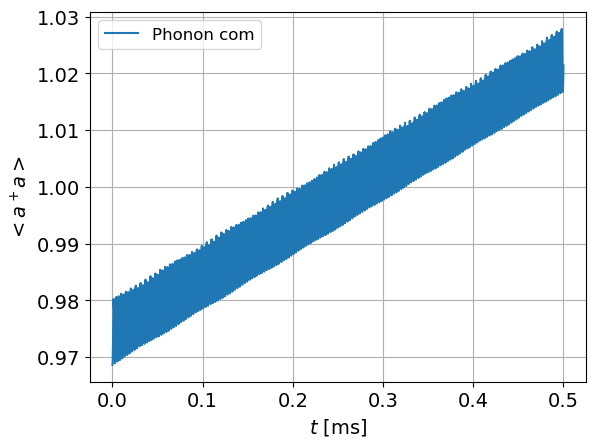

In [192]:
#%%plot phonon population 
mp_state1 = expect(elist1[4],result1.states) 
mp_state2 = expect(elist1[5],result1.states) 

pplot = expect(elist1[2], result1.states)
pplot1 = expect(elist1[3], result1.states)

print('Maximum phonon population of highest com phonon space')
print(np.max(mp_state1),'and',np.max(mp_state2))
plt.plot(times,pplot,label = 'Phonon com')
#plt.plot(times,pplot1,label = 'Phonon tilt')

plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<a^+ a>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

In [193]:
#%%simulate large heating rate, 4 quanta/ms on com mode and 0.04 quanta/ms on tilt
com_cut = 12
ion_sys.pcut= [[com_cut, tilt_cut]]; ion_sys.active_phonon=[[0,1]]
ion_sys.list_para()
#construct Hamiltonian 
clist1 = disp.heating(ion_sys,[4/(2*np.pi),0.04/(2*np.pi)],df=1) 
Heff,arg0 = iscc.H_ord(Bz,ion_sys,laser1) #construct time-dependent H
#construct initial state (initialized as up up)
rho1 = sp_op.ini_state(ion_sys,spin_config,[[0,0]],0)

#thermal initial state
nbarcom=1;nbartilt=0.01;
rho0 = sp_op.rho_thermal(ion_sys,nbar_list=[[nbarcom,nbartilt]],s_state=spin_config,ket = False)

elist3 = [tensor(spin.sz(N,0),sp_op.p_I(ion_sys)),#spin1
          tensor(spin.sz(N,1),sp_op.p_I(ion_sys)),#spin2
          sp_op.phonon_measure(ion_sys,df_p, mindex=0),#com mode population
          sp_op.phonon_measure(ion_sys,df_p, mindex=1),#tilt mode population
          sp_op.pstate_measure(ion_sys,df_p,com_cut-1,0),#population of com_mode cutoff
          sp_op.pstate_measure(ion_sys,df_p,tilt_cut-1,1)] #population of com_mode cutoff]
times =  np.arange(0,0.5,10**(-4))

________________________________________________________________
********************Setup of the Trap************************
number of ions 2
Axial COM (Confining) frequency  1.16  [MHz]
Radial COM (Confining) frequency  2.73 [MHz]
Axial vibrational eigenfrequency [1.16 2.01] MHz
Radial (Transverse) vibrational eigenfrequency [2.73 2.47] [MHz]
Modulation Amplitude for parameteric amplification:  [0] [V]
Modulation Frequency for parameteric amplification:  [0] [MHz]
Trap dimension parameter:  200 [um]
                                                                 
********************Config of Numeric Calculation************************
index of phonon space included in simulation:  [[0, 1]]
corresonding phonon space cutoff  [[12, 3]]
********************Config of Cooling************************
Effective cooling rate  [2. 2.]  [kHz]
Coolant index  [1]
Motional degree of freedom to be cooled:  1
********************Config of Trap Modulation************************
 Modulation Amplit

In [198]:
#solve time dependent ME
print('______________________________________________________________________')
print('solving for complete Hamiltonian')
result2 = mesolve(Heff,rho0,times,clist1,args = arg0,progress_bar=True,options=Options(nsteps=1000)) 

______________________________________________________________________
solving for complete Hamiltonian
10.0%. Run time:   5.65s. Est. time left: 00:00:00:50
20.0%. Run time:  11.38s. Est. time left: 00:00:00:45
30.0%. Run time:  17.19s. Est. time left: 00:00:00:40
40.0%. Run time:  23.00s. Est. time left: 00:00:00:34
50.0%. Run time:  28.98s. Est. time left: 00:00:00:28
60.0%. Run time:  34.90s. Est. time left: 00:00:00:23
70.0%. Run time:  40.82s. Est. time left: 00:00:00:17
80.0%. Run time:  46.70s. Est. time left: 00:00:00:11
90.0%. Run time:  52.59s. Est. time left: 00:00:00:05
Total run time:  58.49s


______________________________________________________________________
solving for pure spin interaction
10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.05s. Est. time left: 00:00:00:00
30.0%. Run time:   0.07s. Est. time left: 00:00:00:00
40.0%. Run time:   0.08s. Est. time left: 00:00:00:00
50.0%. Run time:   0.10s. Est. time left: 00:00:00:00
60.0%. Run time:   0.12s. Est. time left: 00:00:00:00
70.0%. Run time:   0.14s. Est. time left: 00:00:00:00
80.0%. Run time:   0.15s. Est. time left: 00:00:00:00
90.0%. Run time:   0.17s. Est. time left: 00:00:00:00
Total run time:   0.19s


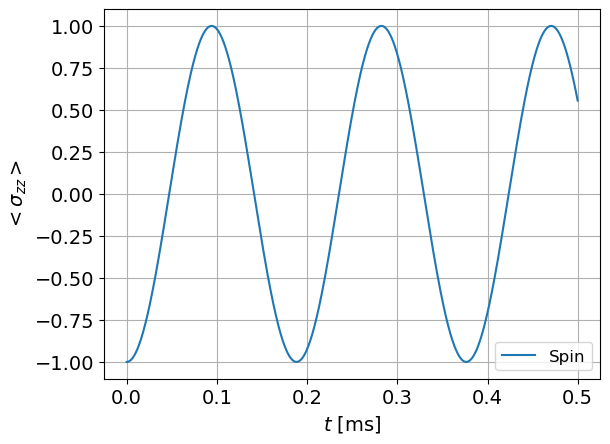

In [202]:
#simulation with a pure spin approximation
psi0 = spin.spin_state(N,[1,1])  
J = iscp.Jt(ion_sys,laser1)
elist2 = [spin.sz(N,0),spin.sz(N,1)]
H = iscp.Hps(J,ion_sys,Bz)
print('______________________________________________________________________')
print('solving for pure spin interaction')
result = mesolve(H,psi0,times,e_ops=elist2,progress_bar=True, options=Options(nsteps=1000))
p0 = 0.5*(result.expect[0]+result.expect[1])
plt.plot(times,p0,label = 'Spin')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$<\sigma_{zz}>$',fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

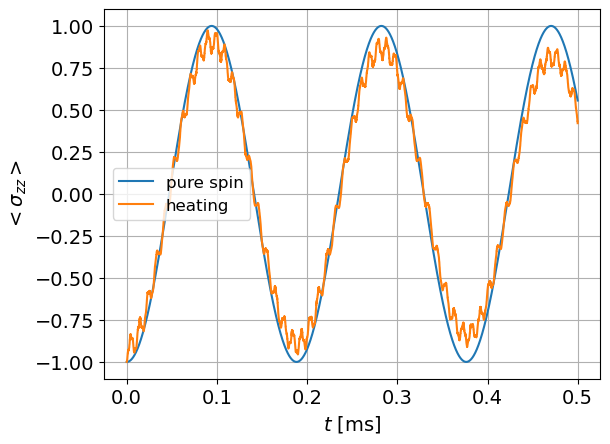

In [203]:
#plot spin dynamics
p2 = 0.5*(expect(elist3[0], result2.states)+expect(elist3[1], result2.states))
plt.plot(times,p0,label = 'pure spin')
plt.plot(times,p2,label = 'heating')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<\sigma_{zz}>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

Maximum phonon population of highest com phonon space
0.019831093737938912 and 0.016502003427252974


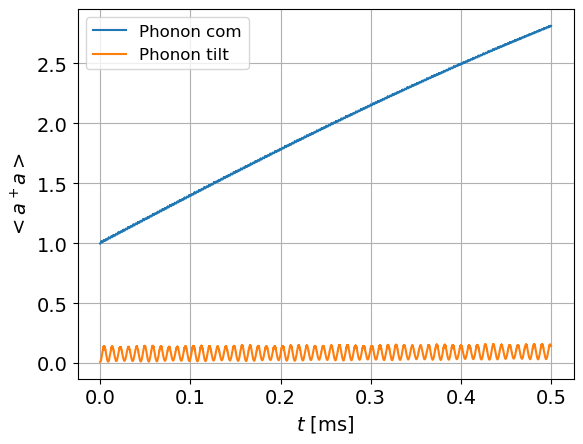

In [204]:
#%%plot phonon population 
mp_state1 = expect(elist3[4],result2.states) 
mp_state2 = expect(elist3[5],result2.states) 

pplot = expect(elist3[2], result2.states)
pplot1 = expect(elist3[3], result2.states)

print('Maximum phonon population of highest com phonon space')
print(np.max(mp_state1),'and',np.max(mp_state2))
plt.plot(times,pplot,label = 'Phonon com')
plt.plot(times,pplot1,label = 'Phonon tilt')

plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<a^+ a>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()